## Import Libraries

In [38]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

## Load Dataset and Display Basic Information 

In [39]:
# Load the dataset
data = pd.read_csv('bank.csv', delimiter=';')

# Display basic information about the dataset
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB
None


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


## Preprocess the Data

In [40]:
# Encode the target variable ('y') into binary format
data['y'] = data['y'].map({'yes': 1, 'no': 0})

# Encode categorical variables using LabelEncoder
categorical_cols = data.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Standardize numerical columns
numerical_cols = data.select_dtypes(include=['int64', 'float64']).drop('y', axis=1).columns
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Check the processed data
data.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,-1.056270,10,1,0,0,0.121072,0,0,0,0.374052,10,-0.711861,-0.576829,-0.407218,-0.320413,3,0
1,-0.772583,7,1,1,0,1.118644,1,1,0,-0.596026,8,-0.169194,-0.576829,2.989044,2.041734,0,0
2,-0.583458,4,2,2,0,-0.024144,1,0,0,0.010273,0,-0.303898,-0.576829,2.899143,0.270124,0,0
3,-1.056270,4,1,2,0,0.017726,1,1,2,-1.566105,6,-0.250017,0.387967,-0.407218,-0.320413,3,0
4,1.686036,1,1,1,0,-0.472753,1,0,2,-1.323585,8,-0.146102,-0.576829,-0.407218,-0.320413,3,0


## Feature Selection 

In [41]:
# Feature Selection using SelectKBest with mutual information
X = data.drop('y', axis=1)  # Features
y = data['y']               # Target

# Select top 10 features
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_new = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]

# Display selected features and their scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_
}).sort_values(by='Score', ascending=False)

print("Top Selected Features:")
print(selected_features)
feature_scores.head(10)


Top Selected Features:
Index(['age', 'balance', 'loan', 'contact', 'day', 'month', 'duration',
       'pdays', 'previous', 'poutcome'],
      dtype='object')


,Feature,Score
11,duration,0.068498
13,pdays,0.023764
15,poutcome,0.020623
14,previous,0.014231
10,month,0.013423
8,contact,0.012672
9,day,0.008234
5,balance,0.007209
0,age,0.006038
7,loan,0.005216


## Models Training 

In [42]:
# Prepare data with selected features
X_selected = X[selected_features]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42, stratify=y)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Train and evaluate each model
results = []

for name, model in models.items():
    # Perform 5-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1')
    
    # Fit the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'CV F1 Score': np.mean(scores)
    })

# Display results
results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy  Precision    Recall  F1 Score  CV F1 Score
0  Logistic Regression  0.884304   0.490909  0.173077  0.255924     0.302270
1        Decision Tree  0.868091   0.422819  0.403846  0.413115     0.417768
2        Random Forest  0.893884   0.573171  0.301282  0.394958     0.466604


## Feature Impotance Analysis for Random Forest

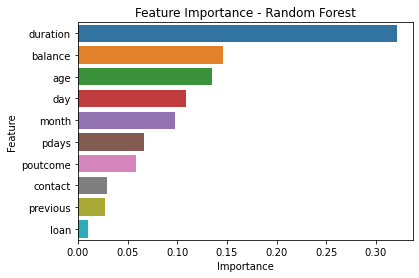

,Feature,Importance
6,duration,0.321023
1,balance,0.145931
0,age,0.135185
4,day,0.108699
5,month,0.097506
7,pdays,0.066234
9,poutcome,0.058938
3,contact,0.029074
8,previous,0.027116
2,loan,0.010295


In [43]:
# Extract feature importances from Random Forest
rf_model = models['Random Forest']
feature_importances = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance - Random Forest')
plt.show()

feature_importances


## Final Evaluation

In [44]:
# Display the overall evaluation results
print("Model Comparison:")
print(results_df)

# Detailed analysis of the best model
best_model_name = results_df.sort_values(by='F1 Score', ascending=False).iloc[0]['Model']
print(f"Best Model: {best_model_name}")

if best_model_name == 'Random Forest':
    print("Feature Importance Analysis:")
    print(feature_importances)


Model Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score  CV F1 Score
0  Logistic Regression  0.884304   0.490909  0.173077  0.255924     0.302270
1        Decision Tree  0.868091   0.422819  0.403846  0.413115     0.417768
2        Random Forest  0.893884   0.573171  0.301282  0.394958     0.466604
Best Model: Decision Tree
